# Developing a Multi-Input Model for OCR Classification

Help an insurance company digitize claim documents by scanning IDs and classifying them as primary or secondary IDs. The trained Optical Character Recognition (OCR) model uses images and insurance types (5 types) to label IDs (2 types) for each image-insurance type pair.

This project demonstrates how to build and train a multi-input neural network using PyTorch. The model learns to classify scanned ID codes based on both image data and categorical type information.

This is a practice project inspired by DataCamp, and the dataset is not included for public release. Additional steps have been included from the original project, including plots, model validation, and model evaluation.

- Instructor: **Abhilash V J**
- Collaborator: **Francesca Donadoni**
- First Completed: May 15, 2025

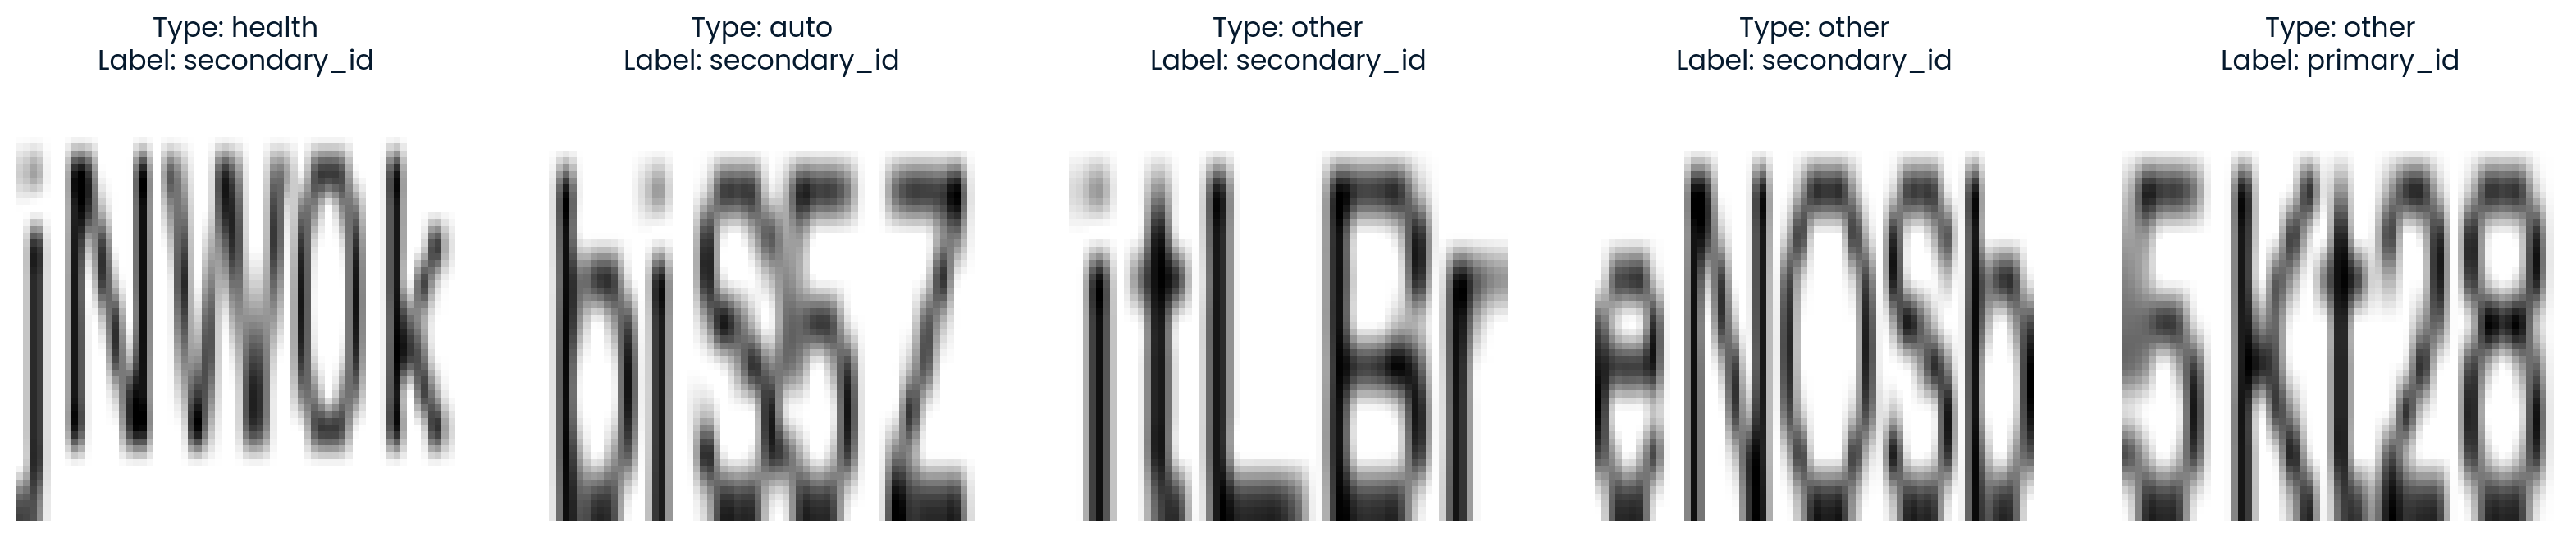

In [8]:
# DataCamp Setup Code

# Import the necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from project_utils import ProjectDataset
import pickle 
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim

# Load the data
dataset = pickle.load(open('ocr_insurance_dataset.pkl', 'rb'))

# Define a function to visualize codes with their corresponding types and labels 
def show_dataset_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, min(num_images, len(dataset)), figsize=(20, 4))
    for ax, idx in zip(axes, np.random.choice(len(dataset),min(num_images, len(dataset)), False)):
        img, lbl = dataset[idx]
        ax.imshow((img[0].numpy() * 255).astype(np.uint8).reshape(64,64), cmap='gray'), ax.axis('off')
        ax.set_title(f"Type: {list(dataset.type_mapping.keys())[img[1].tolist().index(1)]}\nLabel: {list(dataset.label_mapping.keys())[list(dataset.label_mapping.values()).index(lbl)]}")
    plt.show()

# Inspect 5 codes images from the dataset
show_dataset_images(dataset)

In [9]:
# Define a multi-input neural network for OCR classification
class OCRModel(nn.Module):
    def __init__(self):
        super().__init__()

        # Convolutional layers for image input (1x64x64)
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),  # 16x64x64
            nn.MaxPool2d(kernel_size=2),  # 16x32x32
            nn.ReLU(),
            nn.Flatten(),                 # 16*32*32
            nn.Linear(16*32*32, 128)      # Output: 128-dim image feature
        )

        # Fully connected layer for type vector (5 classes)
        self.type_layer = nn.Sequential(
            nn.Linear(5, 10),  # One-hot input: intermediate type features
            nn.ReLU()
        )

        # Classifier combines image + type features
        self.classifier = nn.Sequential(
            nn.Linear(128 + 10, 64),  # Final prediction over 64 categories
        )

    def forward(self, x_image, x_type):
        # Forward pass through each sub-network
        x_image = self.image_layer(x_image)
        x_type = self.type_layer(x_type)

        # Concatenate feature vectors from image and type
        x_combined = torch.cat((x_image, x_type), dim=1)

        # Final prediction
        return self.classifier(x_combined)

## Training the Model
This section trains the OCRModel using both image and type inputs, and monitors loss and accuracy over 10 epochs.

In [10]:
# Split the dataset into 80% training and 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Initialize model, loss, and optimizer
model = OCRModel()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_val_loss = float('inf')  # for saving best model

# Train for 10 epochs
for epoch in range(10):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for (x_image, x_type), labels in train_loader:
        optimizer.zero_grad()
        outputs = model(x_image, x_type)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for (x_image, x_type), labels in val_loader:
            outputs = model(x_image, x_type)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    avg_val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Save best model by validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model.pt')

    print(f"Epoch {epoch+1}, "
          f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
          f"Train Acc: {train_accuracy:.2%}, Val Acc: {val_accuracy:.2%}")

Epoch 1, Train Loss: 4.7140, Val Loss: 3.5302, Train Acc: 30.00%, Val Acc: 50.00%
Epoch 2, Train Loss: 4.0811, Val Loss: 3.2663, Train Acc: 51.25%, Val Acc: 50.00%
Epoch 3, Train Loss: 2.0582, Val Loss: 0.7873, Train Acc: 48.75%, Val Acc: 50.00%
Epoch 4, Train Loss: 1.3795, Val Loss: 0.7525, Train Acc: 58.75%, Val Acc: 55.00%
Epoch 5, Train Loss: 0.9162, Val Loss: 0.5900, Train Acc: 65.00%, Val Acc: 70.00%
Epoch 6, Train Loss: 0.5881, Val Loss: 0.5905, Train Acc: 71.25%, Val Acc: 70.00%
Epoch 7, Train Loss: 0.5772, Val Loss: 0.7462, Train Acc: 70.00%, Val Acc: 60.00%
Epoch 8, Train Loss: 0.4657, Val Loss: 0.5843, Train Acc: 76.25%, Val Acc: 65.00%
Epoch 9, Train Loss: 0.3859, Val Loss: 0.5667, Train Acc: 81.25%, Val Acc: 75.00%
Epoch 10, Train Loss: 0.3920, Val Loss: 0.8676, Train Acc: 78.75%, Val Acc: 55.00%


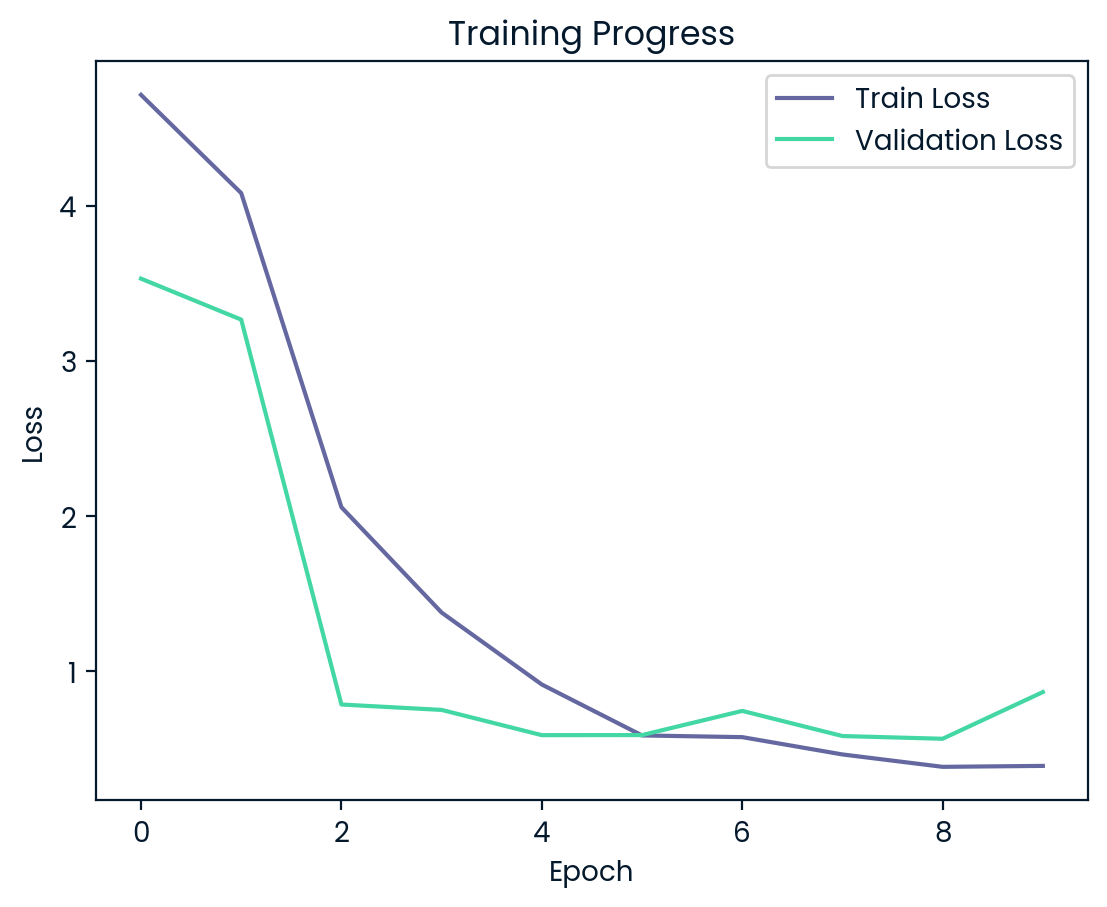

In [11]:
# Plot Loss over Epochs
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Progress')
plt.show()

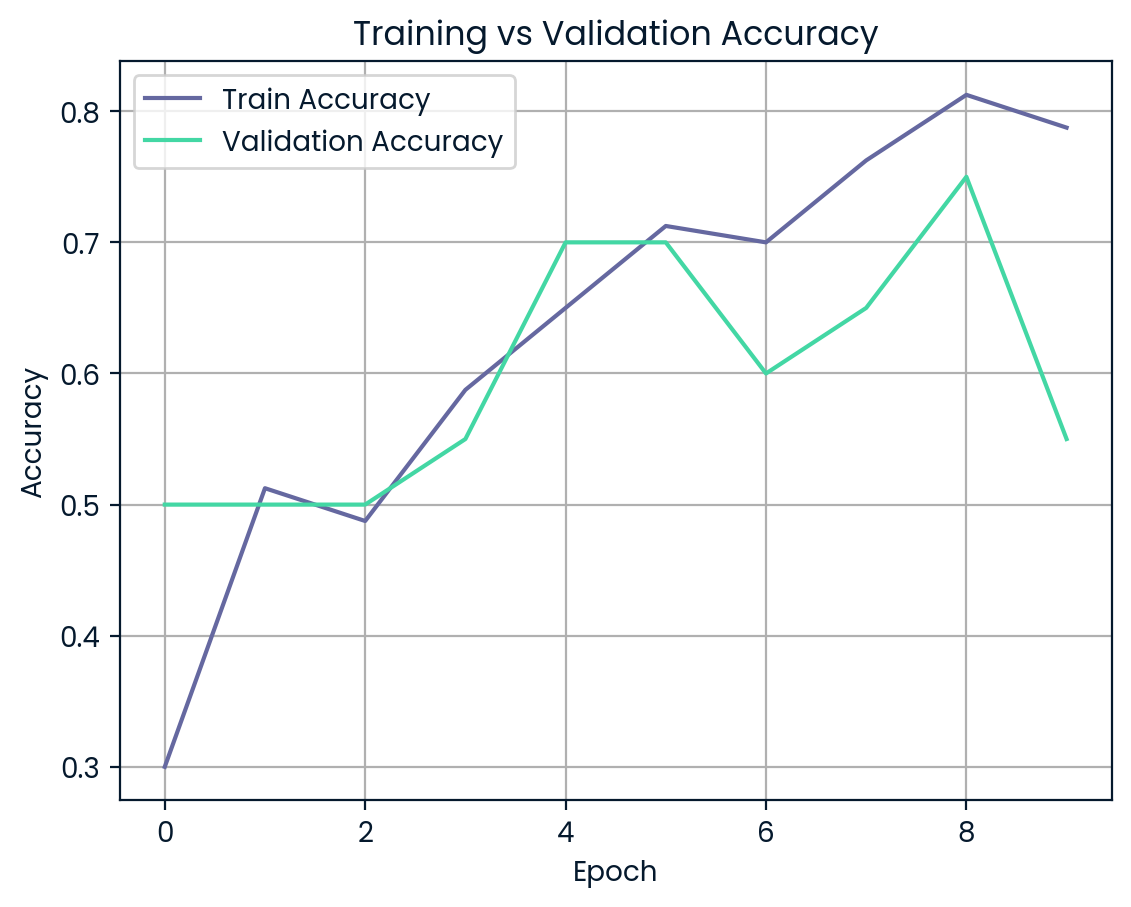

In [12]:
# Plot Accuracy over Epochs
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.show()

In [13]:
# Model Evaluation
def evaluate_model(model, dataloader, label_mapping=None):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for (x_image, x_type), labels in dataloader:
            outputs = model(x_image, x_type)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.2%}")

    if label_mapping:
        from sklearn.metrics import classification_report
        print(classification_report(all_labels, all_preds, target_names=list(label_mapping.keys())))

    return accuracy

In [14]:
# Load the best model (based on validation loss) and evaluate
model.load_state_dict(torch.load('best_model.pt'))
evaluate_model(model, val_loader, label_mapping=dataset.label_mapping)

Accuracy: 75.00%
              precision    recall  f1-score   support

  primary_id       0.73      0.80      0.76        10
secondary_id       0.78      0.70      0.74        10

    accuracy                           0.75        20
   macro avg       0.75      0.75      0.75        20
weighted avg       0.75      0.75      0.75        20



0.75